# Aim and motivation
The primary reason for this notebook is to practice and use RNNs for various tasks and applications. First of which is time series data. RNNs have truly changed the way sequential data is forecasted.

## Recurrent Neural Networks (RNNs)

In a **recurrent neural network (RNN)**, we store the output activations from one or more of the network’s layers—often the *hidden layer* activations. When we feed the next input example into the network, we include these previously stored outputs as **additional inputs**.

You can think of these additional inputs as being **concatenated** to the end of the “normal” inputs to the previous layer.

For example:
* Suppose a hidden layer has:
  * 10 regular input nodes
  * 128 hidden nodes
* If you feed the layer’s outputs back into itself (à la *Elman network*), the layer would now receive **138 total inputs** (10 original + 128 recurrent).

Of course, the **first time** you compute the output of the network, you’ll need to initialize those extra 128 inputs—typically with zeros or some default values.

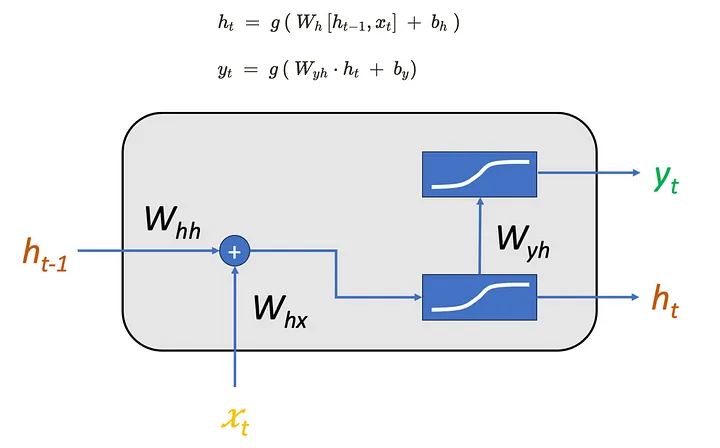

## Limitations of RNNs: The Vanishing Gradient Problem

Even though **Recurrent Neural Networks (RNNs)** are quite powerful, they suffer from the **vanishing gradient problem**, which limits their ability to learn from long-term dependencies.

RNNs are typically effective at capturing information from **3–4 previous time steps**, but performance significantly degrades when dealing with longer sequences. Because of this, we don’t rely solely on regular RNNs for sequence modeling tasks.

Instead, we use a more advanced type of RNN:

> ### **Long Short-Term Memory Networks (LSTMs)**
>
> LSTMs are specially designed to handle long-range dependencies and overcome the vanishing gradient problem.

### What is the Vanishing Gradient Problem?

The **vanishing gradient problem** is a common difficulty encountered when training artificial neural networks using **gradient-based optimization methods** such as backpropagation.

During training:

* Each weight in the network is updated based on the **partial derivative of the error** with respect to that weight.
* If this gradient is **very small**, the corresponding weight receives only a minimal update.
* In extreme cases, the gradients become so small that weights **stop updating altogether**, halting the learning process.

#### Why does this happen?

* Traditional activation functions (like the **tanh** function) produce gradients in the range *(0, 1)*.
* During backpropagation, gradients are calculated using the **chain rule** across many layers.
* Multiplying many small values (gradients) together causes the final gradient for earlier layers to **shrink exponentially** with network depth.

> As a result, the **front layers** (closer to the input) learn very slowly or not at all.

## Long Short-Term Memory (LSTM)

**Long Short-Term Memory (LSTM)** units—also called **LSTM blocks**—are the fundamental building components of certain types of **recurrent neural networks (RNNs)**. An RNN composed of LSTM units is often referred to as an **LSTM network**.

### Key Components of an LSTM Unit

A typical LSTM unit consists of:

* **Cell** – Maintains the internal memory across time steps.
* **Input gate** – Controls how much new information flows into the cell.
* **Forget gate** – Decides what information from the cell state should be discarded.
* **Output gate** – Determines how much of the cell state should be output.

The **cell** is the core component responsible for “remembering” values over long time intervals, which is why "memory" is a central concept in LSTMs.

Each gate behaves like a standard artificial neuron:

* It performs a **weighted sum** of its inputs.
* Passes the result through an **activation function** (typically sigmoid or tanh).
* Acts as a **regulator** for the flow of information.

These gates interact with the cell to control how information is stored, forgotten, or passed on at each time step.

### Why "Long Short-Term"?

The name **"Long Short-Term Memory"** refers to the model’s ability to capture **short-term patterns** in data that can be **retained over long durations**. This is in contrast to standard RNNs, which tend to forget long-term dependencies due to the **vanishing gradient problem**.

### Applications

LSTMs are well-suited for tasks involving:

* **Time series prediction**
* **Natural language processing (NLP)**
* **Speech recognition**
* **Music generation**

They are especially effective when the time lags between important events are **variable and unknown**.

>  LSTMs were specifically designed to address the **vanishing and exploding gradient problems** that hinder training of traditional RNNs.

<img src="https://cdn-images-1.medium.com/max/1600/0*LyfY3Mow9eCYlj7o.">

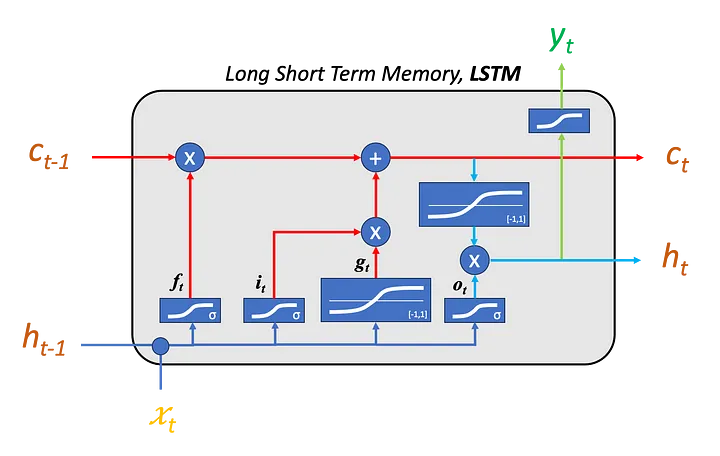

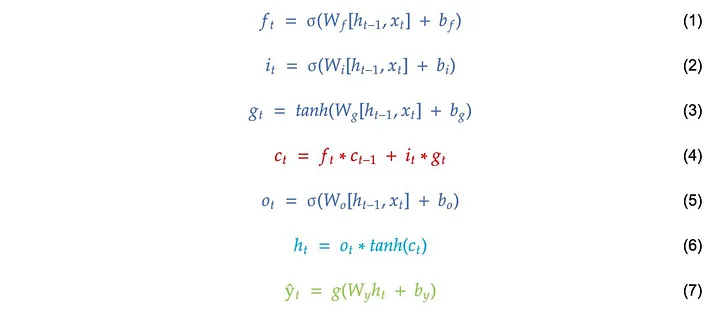

## Components of LSTMs

An **LSTM cell** consists of several key components that work together to manage and control memory and state across time steps.

### Core Components

* **Forget Gate `f`** – A neural network layer with a **sigmoid** activation.
  Determines what portion of the past cell state should be forgotten.

* **Candidate Layer `~C`** – A neural network layer with a **tanh** activation.
  Proposes new candidate values that could be added to the memory.

* **Input Gate `i`** – A neural network layer with a **sigmoid** activation.
  Decides how much of the candidate values should be added to the memory.

* **Output Gate `o`** – A neural network layer with a **sigmoid** activation.
  Controls how much of the memory should be output as the hidden state.

* **Hidden State `H`** – A vector representing the output of the LSTM at the current time step.

* **Memory State `C`** – A vector that stores the internal memory of the LSTM across time steps.

### Inputs and Outputs at Time Step *t*

At any given time step **t**, the LSTM cell receives:

* **Inputs**:

  * `Xₜ` – Current input
  * `Hₜ₋₁` – Previous hidden state
  * `Cₜ₋₁` – Previous memory state

* **Outputs**:

  * `Hₜ` – Current hidden state
  * `Cₜ` – Current memory state


## Working of Gates in LSTMs

The **LSTM cell** uses gates and element-wise operations to manage memory and output at each time step.

### Step 1: Forget Gate Operation

The cell first uses the **forget gate** $f_t$ to decide which parts of the **previous memory state** $C_{t-1}$ to retain or forget.

* If $f_t = 0$, the corresponding part of $C_{t-1}$ is completely forgotten.
* If $f_t = 1$, it is fully retained.

$$
C_t = C_{t-1} \cdot f_t
$$

### Step 2: Update Memory with Input Gate

The **input gate** $i_t$ and the **candidate memory** $\tilde{C}_t$ (generated via a tanh activation) are used to update the memory:

$$
C_t = C_t + (i_t \cdot \tilde{C}_t)
$$

This step adds new, relevant information to the memory.

### Step 3: Compute the Output

The **hidden state** $H_t$ is then computed by applying the `tanh` function to the updated memory and an output gate $o_t$:

$$
H_t = o_t\cdot\tanh(C_t)
$$

### And now we get to the code...
I will use LSTMs for predicting the price of stocks of IBM for the year 2017

In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [ ]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [ ]:
# First, we get the data
dataset = pd.read_csv('../time-series-analysis/input/stock-time-series-20050101-to-20171231/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

In [ ]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

In [ ]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [ ]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,len(training_set)):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [ ]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

In [ ]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],
                           dataset["High"]['2017':]),
                           axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

## Gated Recurrent Units (GRU)

Truth be told, that's one awesome score.
But **LSTMs** aren't the only game in town when it comes to advanced recurrent units in deep learning. Another widely used and powerful alternative is the **Gated Recurrent Unit (GRU)**.

It's still an open question which is *better*—**GRU** or **LSTM**—as they often show **comparable performance**. However:

* **GRUs** are generally **easier to train** and require **fewer parameters**.
* **LSTMs** might outperform GRUs on **larger datasets** due to their higher expressiveness.

### What is a GRU?

In simple terms:

* Unlike LSTMs, **GRUs do not use a separate memory unit** ($C_t$).
* GRUs operate directly on **hidden states** to control the flow of information.

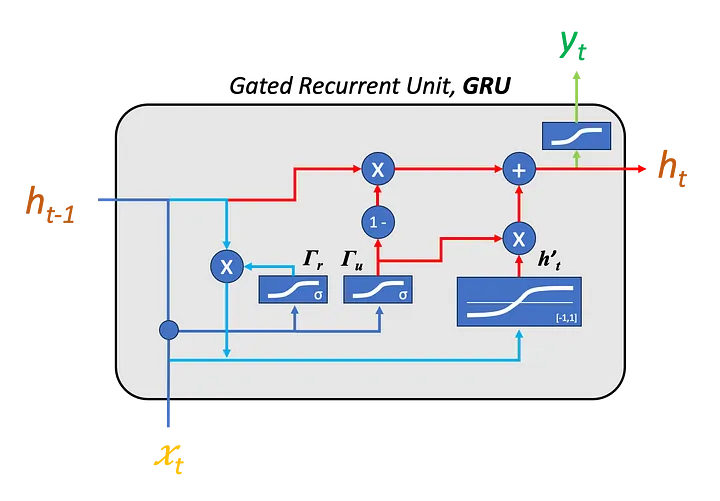

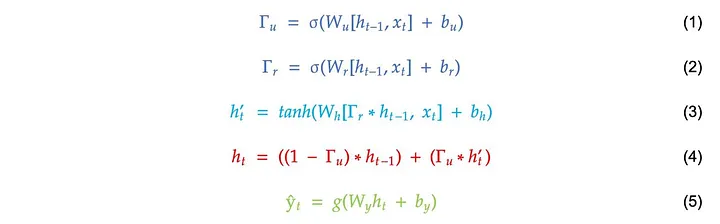

[source](https://medium.com/@bobbycxy/guide-to-rnns-grus-and-lstms-with-diagrams-and-equations-19065aa61cac)

This makes GRUs:

* **Faster to train**
* **Less prone to overfitting on small datasets**
* **Structurally simpler** than LSTMs

### GRU vs LSTM: Key Differences

| Feature              | LSTM                  | GRU           |
| -------------------- | --------------------- | ------------- |
| Memory Cell          | Yes ($C_t$)           | No            |
| Hidden State         | $H_t$                 | $H_t$         |
| Gates                | Input, Forget, Output | Reset, Update |
| Output Gate          | Yes                   | No            |
| Second Non-linearity | Yes (before output)   | No            |
| Parameters           | More                  | Fewer         |
| Training             | Slower                | Faster        |

### GRU Gates Explained

* **Reset Gate $\Gamma_r$**:
  Determines **how to combine the new input** with the previous memory.

* **Update Gate $\Gamma_u$**:
  Controls **how much of the past information** to keep.
  It plays a similar role as the **input and forget gates** in LSTMs.

Unlike LSTMs, GRUs **do not have**:

* An **output gate**
* A **second tanh non-linearity** before producing the hidden state

> GRUs strike a balance between **simplicity** and **power**, often matching LSTM performance with less computational overhead.

**Source**: [Quora](https://www.quora.com/Whats-the-difference-between-LSTM-and-GRU-Why-are-GRU-efficient-to-train)


In [ ]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

The current version version uses a dense GRU network with 100 units as opposed to the GRU network with 50 units in previous version

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

In [ ]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [ ]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

## Sequence Generation

Here, we will generate a sequence using **just the initial 60 values** instead of using the last 60 values for every new prediction.

The models above rely on the test set by using the last 60 **true** values to predict the next one (which I’ll call the **benchmark**). This explains why their error is so low.

Strong models *can* achieve similar results when generating sequences, but they require more than just previous data points. For example, in stock prediction, you also need market sentiment, movements of related stocks, and much more. So, don’t expect a remotely accurate plot here—the error will be significant.

### Model Choice and Results

We will use the **GRU model** for this sequence generation. You can also try this with LSTMs.

I modified the GRU model from above to get the best possible sequence. I ran the model four times:

* Twice, the error was around **8 to 9**
* Worst case had an error of around **11**

Let's see how these iterations perform.

The previous GRU model is fine too; just some tweaking was required to improve sequence quality.

### Final Note

**The main goal of this kernel is to show how to build RNN models.**
How you predict data and what data you use is up to you.

I can’t provide a 100-line script that automatically trains on your data and gives world-class results. That’s something you need to figure out yourself.

In [ ]:
# Preparing sequence data
initial_sequence = X_train[X_train.shape[0] - 1, :]
sequence = []

for i in range(X_test.shape[0]):
    if i % 20 == 0:
        print(f'finished {i}/{X_test.shape[0]}')
    input_seq = initial_sequence.reshape(1, initial_sequence.shape[0], 1)
    new_prediction = regressorGRU.predict(input_seq, verbose=0)
    initial_sequence = np.append(initial_sequence[1:], new_prediction[0, 0])
    sequence.append(new_prediction[0, 0])

sequence = sc.inverse_transform(np.array(sequence).reshape(-1, 1))


In [ ]:
# Visualizing the sequence
plot_predictions(test_set, sequence)

In [ ]:
# Evaluating the sequence
return_rmse(test_set,sequence)

> Note: Using a **Bidirectional LSTM** is also a good way to make the model stronger. However, this may vary depending on the dataset.
**Applying both LSTM and GRU together gave even better results.**
